In [1]:
import pandas as pd

student_info = pd.read_csv('data/student_info_cleaned.csv')

assessments = pd.read_csv('data/assessments.csv')
courses = pd.read_csv('data/courses.csv') # DONE
student_assessments = pd.read_csv('data/studentAssessment.csv')
 # IDK how to use???
# student_info = pd.read_csv('data/studentInfo.csv')
registration = pd.read_csv('data/studentRegistration.csv')
student_vle= pd.read_csv('data/studentVle.csv')
vle = pd.read_csv('data/vle.csv')

datasets = {
    'assessments':assessments,
    'courses':courses,
    'student_assessments':student_assessments,
    'student_info':student_info,
    'registration':registration,
    'student_vle':student_vle,
    'vle':vle}

student_df = student_info.merge(registration, how='inner', on=["code_module", "code_presentation", "id_student"])
student_df = student_df.drop(columns='date_unregistration')

svle = student_vle.groupby(['code_module', 'code_presentation', 'id_student']).agg({'sum_click': ['mean', 'sum'], 'date': 'nunique', 'id_site': 'nunique'}).reset_index()
svle.columns = ['code_module', 'code_presentation', 'id_student', 'mean_sum_click', 'total_sum_click', 'unique_date_count', 'unique_id_site_count']

svle = pd.merge(svle, courses, on=['code_module', 'code_presentation'], how='left')
svle['avg click/day'] =  svle['total_sum_click'] / svle['module_presentation_length']

svle = svle.rename(columns={'unique_date_count': 'days_logged', 'unique_id_site_count': 'material_interactions', 'module_presentation_length': 'module_length'})

vle_n = vle.groupby(['code_module', 'code_presentation'])['id_site'].nunique().reset_index()
svle = pd.merge(svle, vle_n, on=['code_module', 'code_presentation'], how='left')
svle['% material interaction'] =  100*svle['material_interactions'] / svle['id_site']

assessment_counts = assessments.groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().reset_index(name='count')
assessment_pivot = assessment_counts.pivot_table(index=['code_module', 'code_presentation'], columns='assessment_type', values='count', fill_value=0).reset_index()
assessment_pivot.columns.name = None  
assessment_pivot.columns = ['code_module', 'code_presentation', 'CMA', 'Exam', 'TMA']
svle = pd.merge(svle, assessment_pivot, on=['code_module', 'code_presentation'], how='left')

df_all = pd.merge(svle, student_df, on=['code_module', 'code_presentation', 'id_student'], how='inner')
columns_to_move = ['final_result', 'score', 'id_student']
df_all = df_all[columns_to_move + [col for col in df_all.columns if col not in columns_to_move]]

df_all.head()

,final_result,score,id_student,code_module,code_presentation,mean_sum_click,total_sum_click,days_logged,material_interactions,module_length,...,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,grade,studied_credits_binned,date_registration
0,Pass,82.4,11391,AAA,2013J,4.765306,934.0,40,55,268,...,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,A-,201+,-159.0
1,Pass,65.4,28400,AAA,2013J,3.337209,1435.0,80,84,268,...,Scotland,HE Qualification,20-30%,35-55,0,60,N,C,30-60,-53.0
2,Pass,76.3,31604,AAA,2013J,3.254902,2158.0,123,82,268,...,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,B,30-60,-52.0
3,Pass,55.0,32885,AAA,2013J,2.937500,1034.0,70,66,268,...,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,D,30-60,-176.0
4,Pass,66.9,38053,AAA,2013J,3.381743,2445.0,143,88,268,...,Wales,A Level or Equivalent,80-90%,35-55,0,60,N,C,30-60,-110.0


In [21]:
df_all.shape

(13169, 27)

In [2]:
#drop withdrawn students
df_all = df_all[df_all['final_result'] != 'Withdrawn']

In [3]:
import numpy as np
#order highest_education, imd_band, age_band, disability, studied_credits_binned, final_result
highest_education = {
    'No Formal quals': 0,
    'Lower Than A Level': 1,
    'A Level or Equivalent': 2,
    'HE Qualification': 3,
    'Post Graduate Qualification': 4
}

imd_band = {
    np.nan: -1,
    '0-10%': 0,
    '10-20': 1,
    '20-30%': 2,
    '30-40%': 3,
    '40-50%': 4,
    '50-60%': 5,
    '60-70%': 6,
    '70-80%': 7,
    '80-90%': 8,
    '90-100%': 9
}

age_band = {
    '0-35': 0,
    '35-55': 1,
    '55<=': 2
}

disability = {
    'N': 0,
    'Y': 1
}

studied_credits_binned = {
    '30-60': 0,
    '61-100': 1,
    '101-200': 2,
    '201+': 3
}

final_result = {
    'Fail': 0,
    'Pass': 1,
    'Distinction': 1,
    'Withdrawn': 0
}

data_dummies = pd.get_dummies(df_all, columns=['code_module', 'code_presentation', 'gender', 'region'])
data_dummies['highest_education'] = data_dummies['highest_education'].map(highest_education)
data_dummies['imd_band'] = data_dummies['imd_band'].map(imd_band)
data_dummies['age_band'] = data_dummies['age_band'].map(age_band)
data_dummies['disability'] = data_dummies['disability'].map(disability)
data_dummies['studied_credits_binned'] = data_dummies['studied_credits_binned'].map(studied_credits_binned)
data_dummies['final_result'] = data_dummies['final_result'].map(final_result)
data_dummies.shape

(13169, 47)

In [4]:
data_dummies = data_dummies[~((data_dummies['score'] > 50) & (data_dummies['final_result'] == 0))]
data_dummies = data_dummies[~((data_dummies['score'] < 50) & (data_dummies['final_result'] == 1))]

In [5]:
data_dummies.shape

(10737, 47)

model building

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE#pip install imbalanced-learn



X_dummy = data_dummies.drop(['final_result', 'studied_credits', 'id_student', 'score', 'grade'], axis=1)
X_dummy_combined = X_dummy.copy()
X_dummy_combined['score'] = data_dummies['score']
# X_dummy_combined.loc[(X_dummy_combined['score'] < 50) & (y_dummy['final_result'] == 1), 'score'] = 76
# X_dummy_combined.loc[y_dummy['final_result'] == 0, 'score'] = 35


y_dummy = data_dummies[['final_result']]

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_dummy_smote, y_dummy_smote = smote.fit_resample(X_dummy_combined, y_dummy)

y_dummy_smote['score'] = X_dummy_smote['score']
y_dummy['score'] = X_dummy_combined['score']
X_dummy_smote = X_dummy_smote.drop(['score'], axis=1)

/tmp/ipykernel_407/2502644455.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_dummy['score'] = X_dummy_combined['score']


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_dummy_smote = pd.read_csv('data/X_dummy_smote.csv')
y_dummy_smote = pd.read_csv('data/y_dummy_smote.csv')
X_ord_smote = pd.read_csv('data/X_ord_smote.csv')
y_ord_smote = pd.read_csv('data/y_ord_smote.csv')

/var/folders/1z/_j8y7ndj06788g4f84n47dqm0000gn/T/ipykernel_18029/3644116101.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [7]:
print(X_dummy_smote.shape)
print(y_dummy_smote.shape)
y_dummy_smote['final_result'].value_counts()

(18934, 42)
(18934, 2)


1    9467
0    9467
Name: final_result, dtype: int64

In [8]:
X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(X_dummy_smote, y_dummy_smote, test_size=0.2, random_state=42, stratify=y_dummy_smote['final_result'])
# X_train_ord, X_test_ord, y_train_ord, y_test_ord = train_test_split(X_ord_smote, y_ord_smote, test_size=0.2, random_state=42)

logistic regression

In [12]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=20000)
logreg.fit(X_train_dummy, y_train_dummy['final_result'])

y_pred = logreg.predict(X_test_dummy)
acc = accuracy_score(y_test_dummy['final_result'], y_pred)
print('Accuracy Logistic Regression:', acc)

cm = confusion_matrix(y_test_dummy['final_result'], y_pred)

print("Confusion Matrix:")
print(cm)

Accuracy Logistic Regression: 0.9308159493002377
Confusion Matrix:
[[1695  199]
 [  63 1830]]


xgboost

In [ ]:
#XGBoost
from xgboost import XGBClassifier #pip install xgboost
from skopt import BayesSearchCV

# Define the parameter space
param_space = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'min_child_weight': (1, 10),
    'max_depth': (3, 50),
    'max_delta_step': (1, 20),
    'subsample': (0.01, 1.0, 'uniform'),
    'colsample_bytree': (0.01, 1.0, 'uniform'),
    'colsample_bylevel': (0.01, 1.0, 'uniform'),
    'reg_lambda': (1e-9, 1000, 'log-uniform'),
    'reg_alpha': (1e-9, 1.0, 'log-uniform'),
    'gamma': (1e-9, 0.5, 'log-uniform'),
    'n_estimators': (50, 200),
    'scale_pos_weight': (1e-6, 500, 'log-uniform')
}

# Create a BayesSearchCV object
opt_xgb = BayesSearchCV(
    estimator=XGBClassifier(n_jobs=-1),
    search_spaces=param_space,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    n_iter=150,
    verbose=1,
    refit=True,
)

# Run the optimization
opt_xgb.fit(X_train_dummy, y_train_dummy)

In [16]:
from xgboost import XGBClassifier #pip install xgboost
xgb = XGBClassifier()
xgb.fit(X_train_dummy, y_train_dummy['final_result'])

y_pred = xgb.predict(X_test_dummy)
acc = accuracy_score(y_test_dummy['final_result'], y_pred)
print("Accuracy XGBoost:", acc)

cm = confusion_matrix(y_test_dummy['final_result'], y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy XGBoost: 0.9384737259044098
Confusion Matrix:
[[1738  156]
 [  77 1816]]


catboost

In [ ]:
from catboost import CatBoostClassifier
from skopt import BayesSearchCV

counter = [0]

def on_step(optim_result):
    # Increment the counter
    counter[0] += 1
    print(f"Completed iteration {counter[0]}")
    
cb = CatBoostClassifier(verbose=False)

# Define search spaces
param_space = {
    'iterations': (50, 1000),
    'depth': (1, 16),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'random_strength': (1e-9, 10, 'log-uniform'),
    'bagging_temperature': (0.0, 1.0),
    'border_count': (1, 255),
    'l2_leaf_reg': (2, 30),
    'scale_pos_weight':(0.01, 1.0, 'uniform')
}

# Initialize BayesSearchCV
opt_cb = BayesSearchCV(
    estimator=cb,
    search_spaces=param_space,
    scoring='accuracy',
    n_iter=50,
    n_jobs=-1,
    return_train_score=False,
    refit=True,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=42
)

# Fit the model
opt_cb.fit(X_train_dummy, y_train_dummy, callback=on_step)

# Print best parameters and score
print(f'Best parameters: {opt_cb.best_params_}')
print(f'Best score: {opt_cb.best_score_}')

In [19]:
from collections import OrderedDict
from catboost import CatBoostClassifier #pip install catboost

params = OrderedDict([('bagging_temperature', 1.0), ('border_count', 148), ('depth', 13), ('iterations', 976), ('l2_leaf_reg', 30), ('learning_rate', 0.02389354323083735), ('random_strength', 1e-09), ('scale_pos_weight', 0.9510644977326121)])
params['iterations'] = 1000

cb = CatBoostClassifier(**params, verbose=False)
cb.fit(X_train_dummy, y_train_dummy['final_result'])

y_pred = cb.predict(X_test_dummy)
acc = accuracy_score(y_test_dummy['final_result'], y_pred)
print('Accuracy CatBoost:', acc)
cm = confusion_matrix(y_test_dummy['final_result'], y_pred)
print("Confusion Matrix:")
print(cm)

Accuracy CatBoost: 0.9437549511486665
Confusion Matrix:
[[1748  146]
 [  67 1826]]


random forest

In [20]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train_dummy, y_train_dummy['final_result'])

y_pred = rf.predict(X_test_dummy)
acc = accuracy_score(y_test_dummy['final_result'], y_pred)
print('Accuracy Random Forest:', acc)

Accuracy Random Forest: 0.9390018484288355


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
categories = ['code_module', 'code_presentation', 'gender', 'region']
numerical_features = [col for col in X_train_ord.columns if col not in categories]

X_train_dummy = scaler.fit_transform(X_train_dummy)
X_test_dummy = scaler.fit_transform(X_test_dummy)

In [40]:
y_train_dummy.head()

,final_result,score
19901,0,77.718532
14299,1,84.191919
25453,0,84.567035
6573,1,85.348315
11571,0,67.857143


In [22]:
from tensorflow.keras.layers import Dropout, Input, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf

X_train_dummy_np = X_train_dummy.astype('float32')
y_train_dummy_np = y_train_dummy.drop(columns=['final_result']).astype('float32')

input_layer = Input(shape=(X_train_dummy.shape[1],))

dense = Dense(128, kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=l2(0.01))(input_layer)
dense = BatchNormalization()(dense)
dense = tf.keras.activations.relu(dense)
dense = Dropout(0.2)(dense)

dense = Dense(128, kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=l2(0.01))(dense)
dense = BatchNormalization()(dense)
dense = tf.keras.activations.relu(dense)
dense = Dropout(0.2)(dense)

dense = Dense(128, kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=l2(0.01))(dense)
dense = BatchNormalization()(dense)
dense = tf.keras.activations.relu(dense)
dense = Dropout(0.2)(dense)

output = Dense(1, activation='linear')(dense)

model = tf.keras.models.Model(inputs=input_layer, outputs=output)
model2 = tf.keras.models.Model(inputs=input_layer, outputs=output)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
checkpoint2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='model2.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
hist = model.fit(X_train_dummy_np, y_train_dummy_np, epochs=15, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

#misclassified from the first
print("predicting")
preds1 = model.predict(X_train_dummy_np)
precisions, recalls, thresholds = precision_recall_curve(y_train_dummy['final_result'], preds1)
best_threshold = thresholds[np.argmax(precisions + recalls)]
print("misclassifying")

predictions_classified = [1 if y >= best_threshold else 0 for y in preds1.flatten()]
# y_train_dummy_binary = [1 if y >= 50 else 0 for y in y_train_dummy['score']]
np.random.seed(0)
misclassified = np.array(predictions_classified) != np.array(y_train_dummy['final_result'])
misclassified_indices = np.where(misclassified)[0]
correct_indices = np.where(~misclassified)[0]
random_correct_indices = np.random.choice (correct_indices, size=int(len(misclassified_indices)*2), replace=False)
training_indices = np.concatenate([misclassified_indices, random_correct_indices])
X_train2 = X_train_dummy_np.iloc[training_indices]
y_train2 = y_train_dummy_np.iloc[training_indices]

model2.fit(X_train2, y_train2, epochs=30, batch_size=32, validation_split=0.2, callbacks=[checkpoint2])

2024-03-26 20:43:50.365305: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-03-26 20:43:51.439909: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-26 20:43:51.439995: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-03-26 20:43:51.443593: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:ca:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.38GiB deviceMemoryBandwidth: 648.29GiB/s
2024-03-26 20:43:51.443622: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-03-26 20:43:51.446057: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-03-26 

Epoch 1/15


2024-03-26 20:43:53.458900: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


 38/379 [==>...........................] - ETA: 1s - loss: 3592.8462 - accuracy: 9.2491e-04

2024-03-26 20:43:54.126222: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2024-03-26 20:43:54.132094: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


379/379 [==============================] - 4s 6ms/step - loss: 2901.7570 - accuracy: 3.8874e-04 - val_loss: 893.8521 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 893.85205, saving model to model.h5
Epoch 2/15
379/379 [==============================] - 2s 5ms/step - loss: 511.0065 - accuracy: 0.0000e+00 - val_loss: 295.4466 - val_accuracy: 0.0000e+00

Epoch 00002: val_loss improved from 893.85205 to 295.44662, saving model to model.h5
Epoch 3/15
379/379 [==============================] - 2s 5ms/step - loss: 307.8645 - accuracy: 0.0000e+00 - val_loss: 276.8907 - val_accuracy: 0.0000e+00

Epoch 00003: val_loss improved from 295.44662 to 276.89072, saving model to model.h5
Epoch 4/15
379/379 [==============================] - 2s 5ms/step - loss: 280.9080 - accuracy: 0.0000e+00 - val_loss: 239.7257 - val_accuracy: 0.0000e+00

Epoch 00004: val_loss improved from 276.89072 to 239.72572, saving model to model.h5
Epoch 5/15
379/379 [==============================] - 2s

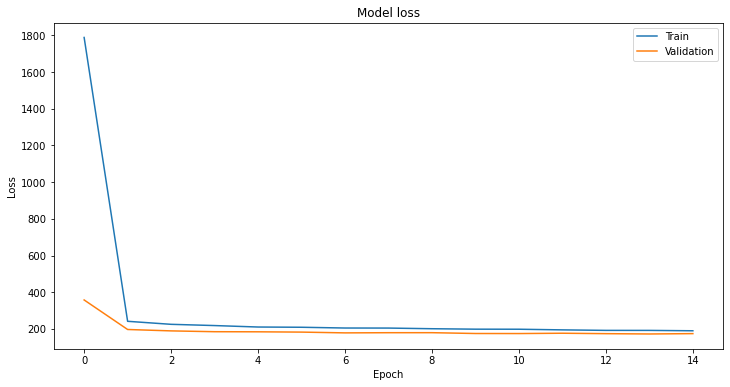

In [146]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [23]:
y_test_dummy['final_result'].value_counts()
test_classified = [0 if y < 50 else 1 for y in y_test_dummy['score'].astype('float32')]
num_zeros = test_classified.count(0)
num_ones = test_classified.count(1)

print(f"Number of 0's: {num_zeros}")
print(f"Number of 1's: {num_ones}")

print('SMOTE')
average_score = y_dummy_smote[y_dummy_smote['final_result'] == 1]['score'].mean()
print(f"Average score where final_result = 1: {average_score}")

average_score = y_dummy_smote[y_dummy_smote['final_result'] == 0]['score'].mean()
print(f"Average score where final_result = 0: {average_score}")

num_entries = len(y_dummy_smote[(y_dummy_smote['final_result'] == 1) & (y_dummy_smote['score'] < 50)])
print(f"Number of entries where final_result = 1 and score < 50: {num_entries}")

num_entries = len(y_dummy_smote[(y_dummy_smote['final_result'] == 0) & (y_dummy_smote['score'] > 50)])
print(f"Number of entries where final_result = 0 and score > 50: {num_entries}")

print('REG')
average_score = y_dummy[y_dummy['final_result'] == 1]['score'].mean()
print(f"Average score where final_result = 1: {average_score}")

average_score = y_dummy[y_dummy['final_result'] == 0]['score'].mean()
print(f"Average score where final_result = 0: {average_score}")

num_entries = len(y_dummy[(y_dummy['final_result'] == 1) & (y_dummy['score'] < 50)])
print(f"Number of entries where final_result = 1 and score < 50: {num_entries}")

num_entries = len(y_dummy[(y_dummy['final_result'] == 0) & (y_dummy['score'] > 50)])
print(f"Number of entries where final_result = 0 and score > 50: {num_entries}")

Number of 0's: 1888
Number of 1's: 1899
SMOTE
Average score where final_result = 1: 74.90150212396232
Average score where final_result = 0: 39.049781113585574
Number of entries where final_result = 1 and score < 50: 0
Number of entries where final_result = 0 and score > 50: 0
REG
Average score where final_result = 1: 74.90150212396232
Average score where final_result = 0: 38.80145189638934
Number of entries where final_result = 1 and score < 50: 0
Number of entries where final_result = 0 and score > 50: 0


In [33]:
from sklearn.metrics import confusion_matrix, precision_recall_curve
from tensorflow.keras.models import load_model

best_model1 = load_model('model.h5')
best_model2 = load_model('model2.h5')

X_test_dummy_np = X_test_dummy.astype('float32')

preds1 = best_model1.predict(X_test_dummy_np)
precisions, recalls, thresholds = precision_recall_curve(y_test_dummy['final_result'], preds1)
best_threshold = thresholds[np.argmax(precisions + recalls)]

print('best threshold', best_threshold)

predictions_classified1 = []
for i, pred in enumerate(preds1):
#     print(i, pred)
    if (pred >= best_threshold):
        predictions_classified1.append(1)
    else:
        predictions_classified1.append(0)
print(len(predictions_classified1))

# y_test_dummy_binary = [1 if y >= 60 else 0 for y in y_test_dummy['score']]
# predictions_classified1 = [1 if y >= 60 else 0 for y in preds1]

acc = accuracy_score(y_test_dummy['final_result'], predictions_classified1)
print("acc1", acc)
cm = confusion_matrix(y_test_dummy['final_result'], predictions_classified1)

print("Confusion Matrix1:")
print(cm)
positive_preds = np.array(predictions_classified1) == 1

preds2 = best_model2.predict(X_test_dummy_np)#[positive_preds])
# preds2 = best_model2.predict(X_test_dummy_np)
average_preds = (preds1*0.45) + (preds2*0.55)



final_preds = np.array(preds1.copy())
final_preds = average_preds#[positive_preds] = average_preds
# final_preds = np.array(preds.copy())

precisions, recalls, thresholds = precision_recall_curve(y_test_dummy['final_result'], final_preds)
best_threshold = thresholds[np.argmax(precisions + recalls)]

print('best threshold', best_threshold)
final_preds_classified = [1 if y >= best_threshold else 0 for y in final_preds.flatten()]






acc = accuracy_score(y_test_dummy['final_result'], final_preds_classified)
print("Accuracy", acc)


cm = confusion_matrix(y_test_dummy['final_result'], final_preds_classified)

print("Confusion Matrix:")
print(cm)


best threshold 55.72512
3787
acc1 0.8803802482175864
Confusion Matrix1:
[[1527  367]
 [  86 1807]]
best threshold 55.455837
Accuracy 0.9094269870609981
Confusion Matrix:
[[1607  287]
 [  56 1837]]


In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
#DO NOT RUN, TAKES FOREVER, OPTIMAL PARAMS PRINTED BELOW

from skopt import BayesSearchCV #pip install scikit-optimize

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from joblib import parallel_backend

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def create_model(neurons, dropout_rate, num_layers, learning_rate):
    input_layer = Input(shape=(X_train_dummy.shape[1],))

    dense = Dense(neurons, kernel_initializer=tf.keras.initializers.HeNormal())(input_layer)
    dense = BatchNormalization()(dense)
    dense = tf.keras.activations.relu(dense)
    dense = Dropout(dropout_rate)(dense)
    
    for i in range(num_layers - 1):
        dense = Dense(neurons, kernel_initializer=tf.keras.initializers.HeNormal())(dense)
        dense = BatchNormalization()(dense)
        dense = tf.keras.activations.relu(dense)
        dense = Dropout(dropout_rate)(dense)

    output = Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

wrapped_create_model = KerasClassifier(build_fn=create_model, verbose=1, epochs=25)

param_space = {
    'neurons': (8, 512),
    'dropout_rate': (0.1, 0.5),
    'num_layers': (1, 5),
    'learning_rate': (0.0001, 0.1)
}

opt = BayesSearchCV(
    wrapped_create_model,
    param_space,
    n_iter=50,
    cv=3,
    n_jobs=1,
    verbose=1
)

opt.fit(X_train_dummy, y_train_dummy)


In [ ]:
best_params = opt.best_params_
print(best_params)

In [ ]:
optimal_parameters = opt.best_params_

optimal_model = create_model(
    neurons=optimal_parameters['neurons'],
    dropout_rate=optimal_parameters['dropout_rate'],
    num_layers=optimal_parameters['num_layers'],
    learning_rate=optimal_parameters['learning_rate']
)

history = optimal_model.fit(X_train_dummy, y_train_dummy, epochs=30, batch_size=32, validation_split=0.2)

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
score = optimal_model.evaluate(X_test_dummy, y_test_dummy)
print("Accuracy (tuned model):", score[1])